In [12]:
%matplotlib inline

import pdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_bfgs
from scipy.io import loadmat
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import cm
from mapFeature import mapFeature
from sigmoid import sigmoid
from plotDecisionBoundary import plotDecisionBoundary
from costFunctionLogisticRegression import costFunctionLogisticRegression
from gradientLogisticRegression import gradientLogisticRegression

## Logistic regression

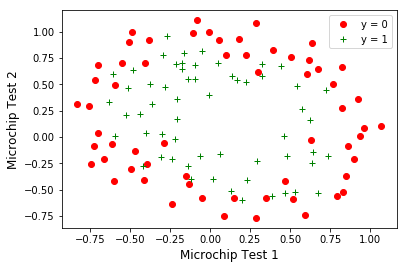

Logistic regression cost with regularization: 0.6931


In [2]:
# load the data
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2].reshape((-1,1))

index0 = np.where(y==0)[0]
index1 = np.where(y==1)[0]

# plot the data
plt.plot(X[index0,0], X[index0,1], 'ro')
plt.plot(X[index1,0], X[index1,1], 'g+')
plt.xlabel('Microchip Test 1', fontsize=12)
plt.ylabel('Microchip Test 2', fontsize=12)
plt.legend(['y = 0', 'y = 1'])
plt.savefig('hw4_q1.png')
plt.show()

# the data points that are not% linearly separable. However, you would still like to use logistic
# regression to classify the data points
# to do so, you introduce more features to use -- in particular, you add
# polynomial features to our data matrix (similar to polynomial regression).
# note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
degree = 6
Xdata = mapFeature(X[:,0], X[:,1], degree)
initial_theta = np.zeros((Xdata.shape[1],1))

# set regularization parameter lambda to 1
lam = 1

# compute and display initial cost and gradient for regularized logistic regression
cost = costFunctionLogisticRegression(initial_theta, Xdata, y, lam)

print('Logistic regression cost with regularization: %.4f' % cost)

## Effect of lambda on logistic regression

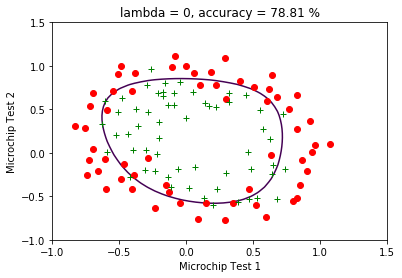

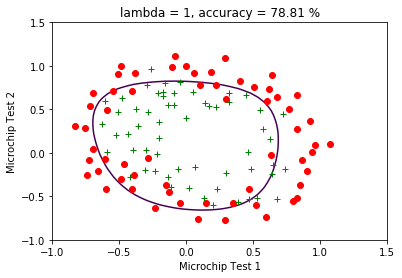

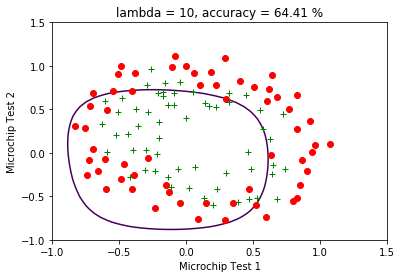

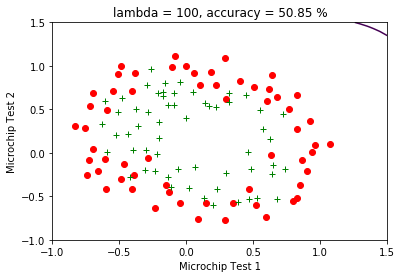

In [3]:
# load the data
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2].reshape((-1,1))

degree = 6
Xdata = mapFeature(X[:,0], X[:,1], degree)
initial_theta = np.zeros((Xdata.shape[1],1))
grad = gradientLogisticRegression(initial_theta, Xdata, y, 0)

# set regularization parameter lambda to 1
lam = [0, 1, 10, 100]

threshold = 0.5

for lm in lam:
    # initial prediction of theta
    grad = gradientLogisticRegression(initial_theta, Xdata, y, lm)
    
    # optimize theta
    theta = fmin_bfgs(costFunctionLogisticRegression, grad, args=(Xdata, y, lm), \
                  fprime=gradientLogisticRegression, disp=False)
    
    # accuracy
    h = sigmoid(np.dot(Xdata, theta))
    h[h >= threshold] = 1
    h[h < threshold] = 0
    acc = (accuracy_score(y, h))
    
    # plot data
    plotDecisionBoundary(theta, Xdata, y, degree)
    plt.title('lambda = %d, accuracy = %.2f %%' % (lm,acc*100))
    plt.xlabel('Microchip Test 1', fontsize=10)
    plt.ylabel('Microchip Test 2', fontsize=10)
    plt.show()

## Logistic regression with cross validation

In [4]:
# load the data
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2].reshape((-1,1))

# model parameters
degree = 6
lam = 0
threshold = 0.5

# logistic regression
method = 'LogisticRegression'
Xdata = mapFeature(X[:,0], X[:,1], degree)

# holding out 20% of the data for testing 
num_folds = 5

# seed random number generator
np.random.seed(2000)

kf = KFold(n_splits=num_folds, shuffle=True)
predictions = np.zeros((y.size))

for train_index, test_index in kf.split(Xdata):
    trainCV, testCV = Xdata[train_index], Xdata[test_index]
    trainGT, testGT = y[train_index], y[test_index]
    
    if method == 'LogisticRegression':
        # for Logistic Regression, we need to solve for theta
        # Insert code here to solve for theta...
        # Using TestDataCV, compute testing set prediction using the model created
        # for Logistic Regression, the model is theta
        # Insert code here to see how well theta works...
        
        initial_theta = np.zeros((Xdata.shape[1],1))
        grad = gradientLogisticRegression(initial_theta, Xdata, y, lam)
    
        # optimize theta
        theta = fmin_bfgs(costFunctionLogisticRegression, grad, args=(trainCV, trainGT, lam), \
                  fprime=gradientLogisticRegression, disp=False)
        
        h = sigmoid(np.dot(testCV, theta))
        h[h >= threshold] = 1
        h[h < threshold] = 0
    elif method == 'KNN':
        disp('KNN not implemented yet')
    else:
        print('Unknown classification method')
    # end
    
    # gather predictions from each run
    predictions[test_index] = h
# end

# generate confusion matrix
confusion_mat = confusion_matrix(y, predictions)
print('confusion matrix: \n', confusion_mat, '\n')

# calculate accuracy from confusion matrix
accuracy1 = np.sum( np.diag(confusion_mat) ) / np.sum(confusion_mat)
print('%s: Lambda = %d, accuracy using confusion matrix = %.2f%% \n' % (method,lam,accuracy1*100))

# calculate accuracy from accuracy_score
accuracy2 = accuracy_score(y, predictions)
print('%s: Lambda = %d, accuracy using scikit learn = %.2f%% \n' % (method,lam,accuracy2*100))



confusion matrix: 
 [[42 18]
 [21 37]] 

LogisticRegression: Lambda = 0, accuracy using confusion matrix = 66.95% 

LogisticRegression: Lambda = 0, accuracy using scikit learn = 66.95% 



## Multi-class logistic regression with cross validation

In [21]:
# load the data
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

n = X.shape[0]
num_labels = np.unique(y).size

# add bias to X
bias = np.ones((n,1))
Xdata = np.hstack((bias,X))

# holding out 20% of the data for testing 
num_folds = 5
lam = 0.1

# classification method to use
method = 'KNN'

# seed random number generator
np.random.seed(2000)

kf = KFold(n_splits=num_folds, shuffle=True)
predictions = np.zeros((y.size))

for train_index, test_index in kf.split(Xdata):
    trainCV, testCV = Xdata[train_index], Xdata[test_index]
    trainGT, testGT = y[train_index], y[test_index]
    
    if method == 'LogisticRegression':
        # initialize theta to store all theta for each label
        all_theta = np.zeros((num_labels,Xdata.shape[1]))
        for c in range(1, num_labels+1):
            initial_theta = np.zeros((Xdata.shape[1],1))
            #pdb.set_trace()
            labeledGT = ((trainGT == c) * 1).reshape((-1,1))
            grad = gradientLogisticRegression(initial_theta, Xdata, y, lam)

            # optimize theta
            theta = fmin_bfgs(costFunctionLogisticRegression, grad, args=(trainCV, labeledGT, lam), \
                      fprime=gradientLogisticRegression, disp=False)

            all_theta[c-1,:] = theta
        #end
        h = sigmoid(np.dot(testCV, all_theta.T))
        h[h >= threshold] = 1
        h[h < threshold] = 0
    elif method == 'KNN':
        knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
        knn.fit(trainCV, trainGT.flatten())
        h = knn.predict(testCV)
    else:
        print('Unknown classification method')
    # end
    
    # gather predictions from each run
    predictions[test_index] = h
# end

# generate confusion matrix
confusion_mat = confusion_matrix(y, predictions)
print('confusion matrix: \n', confusion_mat, '\n')

# calculate accuracy from confusion matrix
accuracy1 = np.sum( np.diag(confusion_mat) ) / np.sum(confusion_mat)
print('%s: Lambda = %d, accuracy using confusion matrix = %.2f%% \n' % (method,lam,accuracy1*100))

# calculate accuracy from accuracy_score
accuracy2 = accuracy_score(y, predictions)
print('%s: Lambda = %d, accuracy using scikit learn = %.2f%% \n' % (method,lam,accuracy2*100))



confusion matrix: 
 [[496   1   2   1   0   0   0   0   0   0]
 [ 15 463   3   0   0   2   9   6   0   2]
 [  4   4 465   0  11   2   5   5   3   1]
 [  8   2   0 467   0   2   1   0  20   0]
 [  5   1   8   6 463   6   0   3   6   2]
 [  2   0   0   0   3 492   0   0   0   3]
 [  8   3   0   5   1   0 472   0  11   0]
 [  9   6   8   5  10   5   0 450   6   1]
 [  2   2   4  17   1   3   8   1 460   2]
 [  1   1   0   0   1   1   0   2   0 494]] 

KNN: Lambda = 0, accuracy using confusion matrix = 94.44% 

KNN: Lambda = 0, accuracy using scikit learn = 94.44% 

